<a href="https://colab.research.google.com/github/YashThakkar21/cloudcast-iOS/blob/main/Airline_Data_Science_Project_%5BFellow%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting future airline revenue from alternative data sources

## Introduction

**Business Context.** You are a research analyst at a large asset management firm. Your team specializes in analyzing the airline industry and predicting future revenues and costs so that they may recommend investment strategies to their clients. Having just completed your data science training, you are eager to apply your newly acquired skills to the problem. Your team already has a lot of data in this domain, but you think that there is additional data that can be used to develop better predictions. Your available data is current up to December 2019 and your goal is to build a model to predict the next quarterly earnings expected to be released in March 2020.

**Business Problem.** Your task is to **build a model to predict the future revenues of United Airlines.**

**Analytical Context.** As part of a large financial services company, the following data has already been *collected, cleaned, and processed* and is available for your team's use:

1. The file **"airline_revenues.csv"** contains the quarterly revenue history for every major US airline.
2. The file **"united_costs.csv"** contains the fuel cost history for United Airlines.
3. The file **"oil_prices.csv"** contains the price history of kerosene.

You have also been looking for additional data to enhance your model. After considering many different sources, you are primarily interested in the Bureau of Transportation Statistics (**BTS**) dataset, which contains seemingly pertinent information for the problem.

The case will proceed as follows: you will (1) look at your team's current data; (2) investigate an alternative data source; (3) create a predictive model.

**Motivation.** As a research analyst at a large asset management firm, it's highly beneficial to gain insights from various data collection procedures. By leveraging advanced data analysis techniques, such as predictive modeling, you can uncover valuable patterns and trends within the available data. In the fast-paced environment of an hedge fund management firm, where decisions must be made swiftly and based on the most accurate information available, your ability to leverage comprehensive data analysis techniques effectively can be a significant asset.

In [1]:
## Load relevant packages
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

import warnings

## Assessing the existing data

Before diving into any data science project, our first step should always be to assess the current data to understand which pieces of information we could be missing. Here, we already have 3 different data sources, so we should look at each one individually and all of them as a whole to figure out how exactly we should supplement them. At every stage, we should keep in mind our objective: **predicting future revenues**. That means we should be thinking about the following question: **"What pieces of information would be useful for predicting airline revenue?"**

![picture](https://upload.wikimedia.org/wikipedia/commons/a/a4/Machine_learning_workflow_diagram.png)

Image Source: <a href="https://commons.wikimedia.org/wiki/File:Machine_learning_workflow_diagram.png">Brylie Christopher Oxley</a>, CC0, via Wikimedia Commons

### Import

Let's load each dataset and then explore them separately:

In [3]:
#Loading Airline Revenue
airline_revenues=pd.read_csv('https://c1-ds4a.s3.amazonaws.com/p72-data-scholars/p72+data/data/airline_revenues.csv')

#Loading United Fuel Costs
united_costs=pd.read_csv('https://c1-ds4a.s3.amazonaws.com/p72-data-scholars/p72+data/data/united_costs')

#Loading Oil Prices
oil_prices=pd.read_csv('https://c1-ds4a.s3.amazonaws.com/p72-data-scholars/p72+data/data/oil_prices')

### Review the initial data sets

Remember that the data provided is already cleaned and prepared for use. Let's first look at the airline revenue data.

In [4]:
airline_revenues.head()

,DATE,YEAR,MONTH,DAY,REVENUE,UNIQUE_CARRIER
0,2006-03-31,2006,3,31,735.4,AS
1,2006-06-30,2006,6,30,873.0,AS
2,2006-09-30,2006,9,30,935.7,AS
3,2006-12-31,2006,12,31,790.3,AS
4,2007-03-31,2007,3,31,759.4,AS


Here are the features of this data:

- **DATE**: the date of the filing
- **YEAR**: Year of filing
- **MONTH**: Month of filing
- **DAY**: Day of filing
- **REVENUE**: Revenue reported (in millions)
- **UNIQUE_CARRIER**: The airline that filed the quarterly revenue

We are only interested in United Airlines because we want to show that this predictive model works for one airline as a proof of concept before building a more general model. As you are new to the team, you are not sure what the code for United is, so you look up the relevant documentation and see that it is **UA**. Since we are only interested in United's revenues, let's simplify this DataFrame:

In [7]:
#Only get United revenues
united_revenues = airline_revenues[airline_revenues['UNIQUE_CARRIER'] == 'UA']

#Since it's filtered, let's keep all the columns except Unique Carrier
united_revenues=united_revenues[['DATE','YEAR','MONTH','DAY','REVENUE']]

united_revenues.head(5)

,DATE,YEAR,MONTH,DAY,REVENUE
429,2006-06-30,2006,6,30,5113.0
430,2006-09-30,2006,9,30,5176.0
431,2006-12-31,2006,12,31,4586.0
432,2007-03-31,2007,3,31,4373.0
433,2007-06-30,2007,6,30,5213.0


Next, let's take a peak at our second and third dataset, which also have date columns and the following interesting features

- **TOTAL_COST**: United Airlines' total fuel costs in dollars.
- **KEROSENE_PRICE**: the price of kerosene (this is important because Kerosene is the oil airplanes use to fly) in in dollars.

In [8]:
united_costs.head(5)

,YEAR,QUARTER,MONTH,TOTAL_COST,DAY,DATE
0,2010,1,1,320169235.0,1,2010-01-01
1,2010,1,2,278634843.0,1,2010-02-01
2,2010,1,3,339915313.0,1,2010-03-01
3,2010,2,4,348193934.0,1,2010-04-01
4,2010,2,5,385441906.0,1,2010-05-01


In [9]:
oil_prices.head(5)

,YEAR,MONTH,DATE,KEROSENE_PRICE
0,2010,1,2010-01-01,2.052
1,2010,2,2010-02-01,1.989
2,2010,3,2010-03-01,2.108
3,2010,4,2010-04-01,2.243
4,2010,5,2010-05-01,2.063


Since both datasets have dates, it would be helpful to visualize:
- United Airlines' Revenue over time
- United Airlines' Fuel Cost over time
- Kerosene Price over time

To accomplish this, we can plot them as time series! But before we delve into the actual plots, let's review some basic information about time series.

## Time Series Introduction



Time series analysis is a fundamental concept in data science that involves studying data points collected, recorded, or observed at successive, evenly spaced time intervals. This branch of analysis is crucial for understanding and predicting trends, patterns, and behaviors over time. Whether it's stock prices, weather patterns, or sales figures, many real-world phenomena can be represented and analyzed as time series data.

Key Components of Time Series Analysis:

- **Time Component**: Time is the independent variable in a time series dataset. It represents the intervals at which data points are collected or observed. Time can be measured in various units such as seconds, minutes, hours, days, months, or years, depending on the context of the data.

- **Data Points**: Data points are the observations recorded at each time interval. These could be numerical values, counts, percentages, or any other measurable quantity relevant to the phenomenon being studied.

- **Trends**: Trends refer to the long-term patterns or movements observed in the time series data. Trends can be upward (indicating growth), downward (indicating decline), or horizontal (indicating stability).

- **Seasonality**: Seasonality reflects periodic fluctuations or patterns that occur at fixed intervals within the time series data. These could be daily, weekly, monthly, or yearly patterns influenced by seasonal factors such as weather, holidays, or economic cycles.

- **Noise**: Noise, also known as random fluctuations or irregular components, represents the variability in the data that cannot be attributed to systematic trends or seasonality. Noise can result from random events, measurement errors, or other unpredictable factors.

![Time Series Analysis](https://upload.wikimedia.org/wikipedia/commons/c/c6/Time_series.png)

Image Source: <a href="https://commons.wikimedia.org/wiki/File:Time_series.png">Google</a>, <a href="https://creativecommons.org/licenses/by-sa/4.0">CC BY-SA 4.0</a>, via Wikimedia Commons

Now that we have the relevant information and a basic understanding of time series, let's plot the data to see what it looks like. Your team uses the following nifty function to plot time series data:

In [10]:
def plot_time_series(dates, values, title, x_label, y_label):
    """
    dates: must be a datetime series for the x-axis
    values: the y axis values to plot
    title: string that goes above the plot
    x_label: string that goes on the x-axis
    y_label: string that goes on the y-axis
    """
    # Set major locator to years
    years_locator = mdates.YearLocator()
    # Set minor locator to months
    months_locator = mdates.MonthLocator()
    # Format to show month and year
    years_format = mdates.DateFormatter('%b %Y') #Format: 'Jan 2023'

    sns.set_style('ticks')
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6) # Adjust figure size as needed

    ax.ticklabel_format(axis='y', style='plain')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.xaxis.set_major_locator(years_locator)
    ax.xaxis.set_major_formatter(years_format)
    ax.xaxis.set_minor_locator(months_locator)

    sns.lineplot(x=dates, y=values, errorbar=None)

    rotation = 45
    plt.setp(ax.get_xticklabels(), rotation=rotation)
    plt.xlabel(x_label, fontsize='16')
    plt.ylabel(y_label, fontsize='16')
    plt.title(title, fontsize='18')

    plt.show()

Let's plot the following:
1. United's revenue over time using `united_revenues`
1. United's fuel cost over time using `united_costs`
1. Kerosene price over time using `oil_prices`

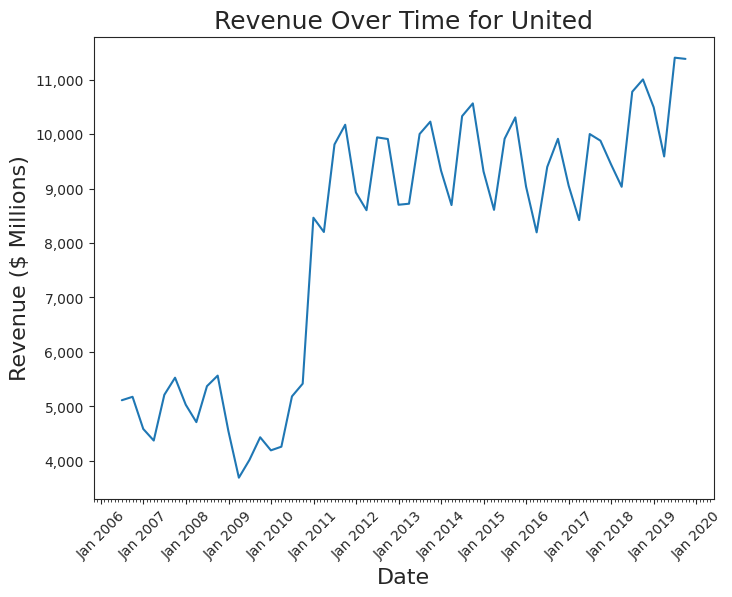

In [11]:
#Convert DATE column to datetime
united_revenues['DATE'] = pd.to_datetime(united_revenues['DATE'])

#Let's call the plot_time_series function
plot_time_series(united_revenues['DATE'], united_revenues['REVENUE'], 'Revenue Over Time for United', 'Date', 'Revenue ($ Millions)')

### Question 1

Are there any interesting patterns you notice in this data?

**Answer.** A merger in 2010 caused the revenue to increase significantly. There's a clear seasonal trend in revenue, where we can see the decrease in revenue towards the end of the year and increase at the beginning.

Now, let's take a look at United fuel costs over time and kerosene prices over time.

### Exercise 1

Using the `plot_time_series` function and the 'Revenue over Time for United' as a reference, prepare the data and plot the 'Fuel Costs over Time for United' and 'Kerosene Price Over Time'.

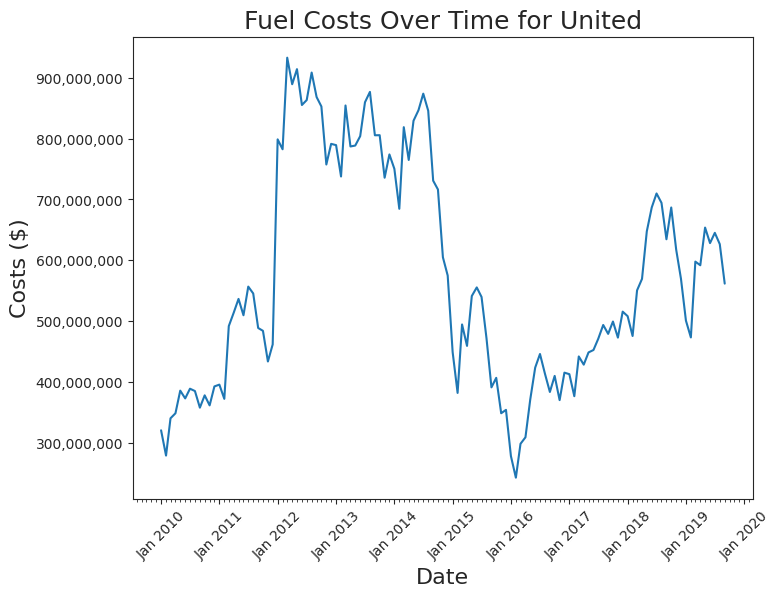

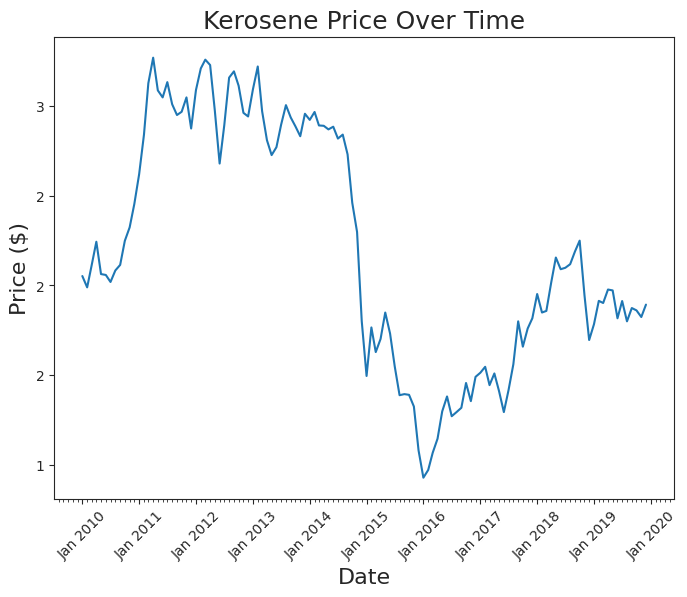

In [ ]:
#Convert DATE column to datetime
united_costs['DATE']=pd.to_datetime(united_costs['DATE'])
oil_prices['DATE']=pd.to_datetime(oil_prices['DATE'])

#Call the plot_time_series function
plot_time_series(united_costs['DATE'], united_costs['TOTAL_COST'], 'Fuel Costs Over Time for United', 'Date', 'Costs ($)')
plot_time_series(oil_prices['DATE'], oil_prices['KEROSENE_PRICE'], 'Kerosene Price Over Time', 'Date', 'Price ($)')

## Reviewing our Data

You might be wondering why we care about the price of an input (like kerosene) when we have the actual fuel cost. The answer lies in the delay between when the data is collected and what is actually happening at any given time.

2. **United Fuel Costs:** This data takes time to acquire, and the company takes 3 months to compute the costs. Thus, if we are in December, you have all the fuel costs up to September of that year.
3. **Oil Prices:** This is a live price that trades publicly. At any given moment in time, we know the exact price of kerosene.

But, what's missing? Is there any data that could give some missing information?

Our goal is to predict revenue. However, all we have is information on the costs from the past and oil prices from the present. Nevertheless, cost is a contributing factor of revenue so it can help build a model for revenue prediction if we make a big assumption (**remember your assumptions**) that the revenue/passenger and cost/passenger are roughly constant in the short term. With our existing data, our model looks something like this:

$$\text{Revenue} = f( \text{Past Costs},  \text{Past Revenue}, \text{Kerosene} )$$

But this does not take into account anything in the present. Also, we know that revenue is directly tied to how many people fly on the airline. Given our assumption, if we could incorporate the number of passengers, then this would be a better model:

$$\text{Revenue} = f( \text{Past Costs}, \text{Past Revenue}, \text{Kerosene}, \text{Number of passengers} )$$

We can think of this model assumption as revenue depending on the cost per passenger. Therefore, if you know past costs and past numbers of passengers, you can train a model to predict revenue in the future based on projected costs per passenger. This motivates us to supplement our current data by trying to find a good measure of the current number of passengers on an airline.


### Supplementing with the BTS data

Now that we know we want to get a prediction of the likely number of passengers on an airline, it would be good to find a dataset of the historical ridership of the airlines. After scouring the Internet, we find the perfect data source from the [Bureau of Transportation Statistics](https://www.bts.gov/browse-statistical-products-and-data/bts-publications/%E2%80%A2-data-bank-28dm-t-100-domestic-market-data-us). Namely, the T-100 Domestic Market (U.S. Carriers) dataset aggregates monthly ridership grouped by airline as well as origin and destination airports. Essentially, each row represents the total number of passengers who flew between two cities for a specific month and airline.

After finding the supplemental data, your team cleans, filters (for United Airlines passengers from 2012 to 2019), and transforms the data to be grouped by month. The resulting dataset is called `united_passengers_by_month` and its key features are:

1. **YEAR:** The year of the flights
1. **MONTH:** The month of the flights
1. **PASSENGERS:** The number of passengers on the flights
1. **DATE:** The date of the flights


In [ ]:
united_passengers_by_month = pd.read_csv('https://c1-ds4a.s3.amazonaws.com/p72-data-scholars/p72+data/data/united_passenger_by_month.csv')
united_passengers_by_month.head(5)

,YEAR,MONTH,PASSENGERS,DATE
0,2012,1,4988564.0,2012-01-01
1,2012,2,4921042.0,2012-02-01
2,2012,3,5952399.0,2012-03-01
3,2012,4,5761602.0,2012-04-01
4,2012,5,5912575.0,2012-05-01


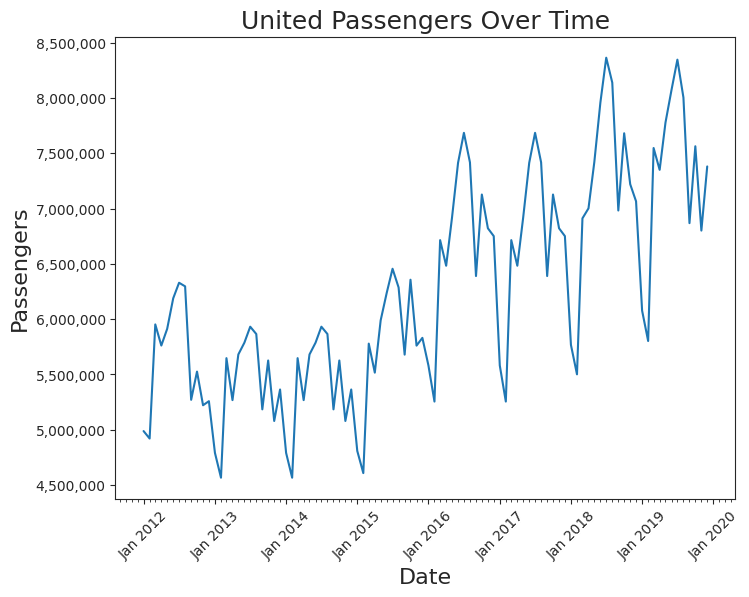

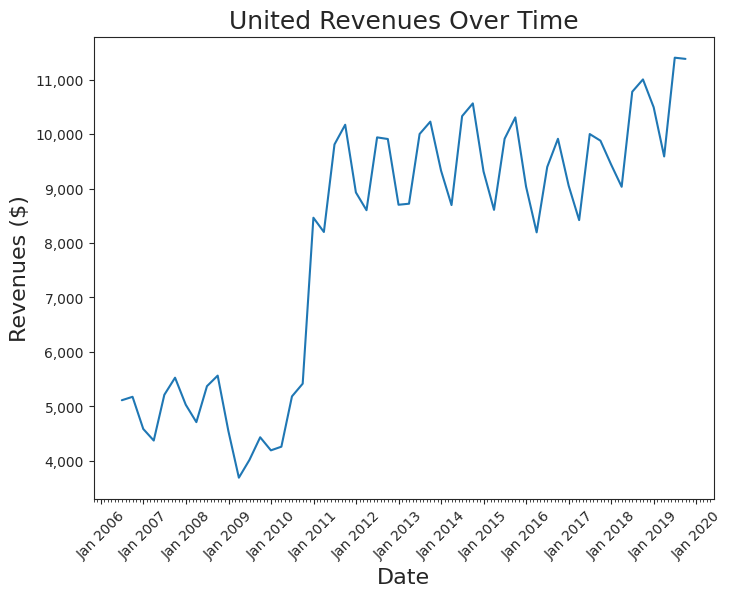

In [ ]:
#Convert date column to datetime
united_passengers_by_month['DATE']=pd.to_datetime(united_passengers_by_month['DATE'])

#Plot and compare time series
plot_time_series(united_passengers_by_month['DATE'], united_passengers_by_month['PASSENGERS'], 'United Passengers Over Time', 'Date', 'Passengers')
plot_time_series(united_revenues['DATE'], united_revenues['REVENUE'], 'United Revenues Over Time', 'Date', 'Revenues ($)')

Based on these plots, we start to wonder if there is a connection between passenger count and revenue.  In essence, we're questioning whether they are correlated. Let's review their correlation.

### Introduction to Correlation

Correlation is a statistical measure that quantifies the strength and direction of the linear relationship between two variables. The formula for correlation is:

\begin{equation}
r_{xy} = \frac{\sum{(x_i - \bar{x})(y_i - \bar{y})}}{\sqrt{\sum{(x_i - \bar{x})^2}\sum{(y_i - \bar{y})^2}}}
\end{equation}

where

*   $r_{xy}$ represents the correlation coefficient between variables $x$ and $y$.
* $x_i$ and $y_i$ are individual data points.
* $\bar{x}$ and $\bar{y}$ are the means (averages) of variables $x$ and $y$ respectively.

The correlation coefficient ranges from -1 to 1, where:

- A value of 1 indicates a perfect **positive correlation**, meaning that as one variable increases, the other variable increases proportionally. Values such as 0.999, 0.90, or 0.85 suggest a strong positive relationship.
- A value of -1 indicates a perfect **negative correlation**, implying that as one variable increases, the other variable decreases proportionally. Values such as -0.999, -0.999, or -0.77 suggest a strong negative relationship.
- A value of 0 indicates **no linear correlation** between the variables. These may look like 0.001, -0.001, 0.25, -.400, etc. (both on the negative and positive side).

![Correlation Picture](https://upload.wikimedia.org/wikipedia/commons/e/e1/Linear_Correlation_Examples.JPG)

Image Source: <a href="https://commons.wikimedia.org/wiki/File:Linear_Correlation_Examples.JPG">Dwendland</a>, <a href="https://creativecommons.org/licenses/by-sa/3.0">CC BY-SA 3.0</a>, via Wikimedia Commons

However, it's crucial to note that correlation does not imply causation. Just because two variables are correlated does not necessarily mean that changes in one variable cause changes in the other. For example, ice cream sales and sunglasses sales are positively correlated, but it's not because buying ice cream causes people to buy sunglasses or vice versa. Correlation simply indicates a relationship between variables, but it does not provide information about the direction of causality or whether a causal relationship exists at all. Here is another example:

![Causation Image](https://upload.wikimedia.org/wikipedia/commons/2/20/Correlation_verses_causation_demonstration_chart.svg)

Image Source: <a href="https://commons.wikimedia.org/wiki/File:Correlation_verses_causation_demonstration_chart.svg">Hephestus-1964</a>, <a href="https://creativecommons.org/licenses/by-sa/4.0">CC BY-SA 4.0</a>, via Wikimedia Commons

#### Correlation between Revenue and Passengers

You ask your team to investigate the correlation between revenue and passengers and after their investigation, they report that the correlation is `0.88444`.

From this, we can see that passengers are highly correlated with revenues. Thus, knowing the number of passengers provides a high quality signal to predict revenues.

Let's get into the modeling part!

## Introduction to Linear Regression Models

Linear regression is a statistical technique used to model the relationship between a dependent variable and one or more independent variables. This statistical technique aims to predict the value of the dependent variable based on the value(s) of the independent variable(s).

*Disclaimer*: Linear regression also assumes independence of observations, which is often not the case in time series data where later observations might depend on earlier ones. For this workshop, we are going to use a linear regression model, as it's typically learned before diving into time series analysis.

There are two main types of linear regression models:
1. simple linear regression
2. multiple linear regression

Linear regression models assume a linear relationship between the dependent variable and the independent variable(s). In simple linear regression, the relationship is represented by a straight line on a scatter plot. In multiple linear regression, the relationship is represented by a linear combination of the independent variables.

The regression equation or line represents the relationship between the dependent variable and the independent variable(s).
In simple linear regression, the equation is $Y = β_0 + β_1X + ε$ and in multiple linear regression, the equation is:

\begin{equation}
Y = β_0 + β_1X_1 + β_2X_2 + ... + β_nX_n + ε
\end{equation}

where:

- $Y$ is the **dependent variable**. The dependent variable, also known as the response variable or output variable, is the variable being studied and measured. It is the variable whose values are predicted by the independent variable. The dependent variable is typically represented on the y-axis of a scatter plot.
- **$β_0$** is the **y-intercept**. The intercept represents the value of the dependent variable when all independent variables are set to zero.  It is the point where the plot intersects the y-axis.
- **$β_1, β_2, ..., β_n$** are the **regression coefficients** or slopes corresponding to the independent variable(s). In simple linear regression, the slope represents the change in the dependent variable for a one-unit change in the independent variable. In multiple linear regression, the regression coefficients represent the change in the dependent variable associated with a one-unit change in the corresponding independent variable, while holding all other independent variables constant. The values indicate the *strength and direction* of the relationship between each independent variable and the dependent variable. A positive slope indicates a positive relationship, while a negative slope indicates a negative relationship.
- **$X$ or $X_1, X_2, ..., Xn$** are the **independent variables**. The independent variable(s), also known as predictor variable(s) or input variable(s), are the variable(s) used to predict the dependent variable.
- **$ε$** is the **error term**.





### Lags in Time Series
When dealing with time series data, lags mean looking at past values of a variable to predict its future behavior. Lags help us understand how things change over time. There are two types:

1. **Autoregressive Lags**: These are past values of the same variable. Including autoregressive lags helps us see how a variable's own past affects its current value. It's like saying what happened before influences what happens next.

2. **Distributed Lags**: These are past values of other variables. Including distributed lags helps us see how past values of different variables affect the current value of our main variable. It's like saying there's a delay or spread-out impact from these other variables over time.

Incorporating the right lags into our models can improve their ability to predict future outcomes, especially for data that changes over time or where there's a delay in how variables influence each other.

## The Model

Now that we have all of our data, let's summarize what we have:

**Dependent Variables:**

1. United passengers: latest available, 3 months ago - ```united_passengers_by_month```
2. United fuel costs: latest available, 3 months ago - ```united_costs```
3. Kerosene price: latest available, present - ```oil_prices```

**Target Variable:**

1. Revenues: Available every quarter

Everything is a time series, so we need to decide how much history we want to feed into the algorithm. Having more history should help with better predictions, but most of the useful information is in the nearby history. We also have to decide which variables to include. Let $P=Passengers$, $C=Costs$, and $K=Kerosene$. Here are two potential model structures:

1. **Minimal Model**: $Revenue_t = f(P_{t-3}, C_{t-3}, K_t)$

  This represents using only the latest passengers and fuel costs. On the other end of the spectrum we could have something like:

2. **Maximal Model**: $Revenue_t = f(P_{t-3}, P_{t-4}, P_{t-5}, P_{t-6}, P_{t-7}, P_{t-8}, P_{t-9}, P_{t-10}, P_{t-11}, P_{t-12}, P_{t-13}, P_{t-14}, C_{t-3}, C_{t-4}, C_{t-5}, C_{t-6}, C_{t-7}, C_{t-8}, C_{t-9}, C_{t-10}, C_{t-11}, C_{t-12}, C_{t-13}, C_{t-14}, K_{t}, K_{t-1}, K_{t-2}, K_{t-3}, K_{t-4}, K_{t-5}, K_{t-6}, K_{t-7}, K_{t-8}, K_{t-9}, K_{t-10}, K_{t-11})$

  which would include the last 12 months of data for every time series we have.

Let's evaluate both of these models. First, we need to introduce **lagged variables** into our data by using the `pandas` ```shift()``` function:

In [ ]:
oil_prices[['KEROSENE_PRICE']].head()
#oil_prices[['KEROSENE_PRICE']].shift(1).head()

,KEROSENE_PRICE
0,2.052
1,1.989
2,2.108
3,2.243
4,2.063


Finally, we have to merge these lagged DataFrames with our target variable and make dummy variables for the quarters of the revenue filing. Dummy variables are used here because the quarters aren't ordinal. That is, if the effect of revenue in the first quarter is $\beta$ then the effect in the fourth quarter will **not** be $4\beta$:

In [ ]:
def make_lag_dfs(num_oil_lag, num_passengers_lag, num_costs_lag):
    X = pd.DataFrame()

    start_date = datetime(2012,1,1)
    end_date = datetime(2020,1,1)

    X = oil_prices[(oil_prices['DATE'] >= start_date) & (oil_prices['DATE'] <= end_date)].copy()

    # oil price lag

    for i in range(num_oil_lag):
        name = f"KEROSENE_PRICE_{i}"
        X[name] = X['KEROSENE_PRICE'].shift(i)

    del X['KEROSENE_PRICE']

    # passengers lag
    columns_to_keep = ['YEAR', 'MONTH', 'PASSENGERS']

    X = X.merge(united_passengers_by_month[
        (united_passengers_by_month['DATE'] >= start_date) & (united_passengers_by_month['DATE'] <= end_date)]
                [columns_to_keep], on=['YEAR', 'MONTH'], how='outer')

    for i in range(3, 3+num_passengers_lag):
        name = f"PASSENGERS_{i}"
        X[name] = X['PASSENGERS'].shift(i)

    del X['PASSENGERS']

    # costs lag
    columns_to_keep = ['YEAR', 'MONTH', 'TOTAL_COST']

    X = X.merge(united_costs[(united_costs['DATE'] >= start_date) & (united_costs['DATE'] <= end_date)]
                [columns_to_keep], on=['YEAR', 'MONTH'], how='outer')

    for i in range(3, 3+num_costs_lag):
        name = f"TOTAL_COST_{i}"
        X[name] = X['TOTAL_COST'].shift(i)

    del X['TOTAL_COST']

    columns_to_keep = ['YEAR', 'MONTH', 'REVENUE']
    X = pd.merge(X, united_revenues[columns_to_keep], on=['YEAR', 'MONTH'])

    X = X.dropna()

    dates = X.apply(lambda r: datetime(r['YEAR'], r['MONTH'], 30) , axis=1)
    del X['DATE']
    del X['YEAR']

    X = pd.get_dummies(X, columns=['MONTH'])

    y = X['REVENUE']
    del X['REVENUE']

    return X, y, dates

X_minimal, y_minimal, dates_minimal = make_lag_dfs(1, 1, 1)
X_maximal, y_maximal, dates_maximal = make_lag_dfs(12, 12, 12)


Let's see the input data for $Revenue_t = f(P_{t-3}, C_{t-3}, K_t)$

In [ ]:
print(X_minimal.shape)
X_minimal.head()

(30, 7)


,KEROSENE_PRICE_0,PASSENGERS_3,TOTAL_COST_3,MONTH_3,MONTH_6,MONTH_9,MONTH_12
1,2.678,5952399.0,933220245.0,False,True,False,False
2,3.191,6188615.0,855369144.0,False,False,True,False
3,2.940,5271258.0,868453153.0,False,False,False,True
4,2.969,5258843.0,791441194.0,True,False,False,False
5,2.769,5647678.0,854589487.0,False,True,False,False


The following is the input data for $Revenue_t = f(P_{t-3}, P_{t-4}, P_{t-5}, P_{t-6}, P_{t-7}, P_{t-8}, P_{t-9}, P_{t-10}, P_{t-11}, P_{t-12}, P_{t-13}, P_{t-14}, C_{t-3}, C_{t-4}, C_{t-5}, C_{t-6}, C_{t-7}, C_{t-8}, C_{t-9}, C_{t-10}, C_{t-11}, C_{t-12}, C_{t-13}, C_{t-14}, K_{t}, K_{t-1}, K_{t-2}, K_{t-3}, K_{t-4}, K_{t-5}, K_{t-6}, K_{t-7}, K_{t-8}, K_{t-9}, K_{t-10}, K_{t-11})$

In [ ]:
print(X_maximal.shape)
X_maximal.head()

(27, 40)


,KEROSENE_PRICE_0,KEROSENE_PRICE_1,KEROSENE_PRICE_2,KEROSENE_PRICE_3,KEROSENE_PRICE_4,KEROSENE_PRICE_5,KEROSENE_PRICE_6,KEROSENE_PRICE_7,KEROSENE_PRICE_8,KEROSENE_PRICE_9,...,TOTAL_COST_9,TOTAL_COST_10,TOTAL_COST_11,TOTAL_COST_12,TOTAL_COST_13,TOTAL_COST_14,MONTH_3,MONTH_6,MONTH_9,MONTH_12
4,2.969,3.218,3.091,2.940,2.960,3.111,3.191,3.156,2.892,2.678,...,855369144.0,914374867.0,889559342.0,933220245.0,782532463.0,798837142.0,True,False,False,False
5,2.769,2.725,2.808,2.969,3.218,3.091,2.940,2.960,3.111,3.191,...,868453153.0,908788163.0,863481608.0,855369144.0,914374867.0,889559342.0,False,True,False,False
6,2.934,3.003,2.894,2.769,2.725,2.808,2.969,3.218,3.091,2.940,...,791441194.0,757525169.0,852963259.0,868453153.0,908788163.0,863481608.0,False,False,True,False
7,2.955,2.830,2.885,2.934,3.003,2.894,2.769,2.725,2.808,2.969,...,854589487.0,737774963.0,789358416.0,791441194.0,757525169.0,852963259.0,False,False,False,True
8,2.890,2.965,2.921,2.955,2.830,2.885,2.934,3.003,2.894,2.769,...,804102435.0,788648855.0,787152648.0,854589487.0,737774963.0,789358416.0,True,False,False,False


As we can see, the price you pay for 12 months of historical data is 3 data points which is pretty significant for 30 overall data points. To assess the performance, we will train on 2012 to 2018 and predict the last 3 data points in 2019.

### Building our model using X_mininal

Let's build the minimal model, $Revenue_t = f(P_{t-3}, C_{t-3}, K_t)$. We begin by splitting the training and testing data. Splitting data into train and test sets is crucial for assessing how well a model performs on unseen data, acting as a proxy for real-world scenarios and verifying its generalizability. Our training data will exclude the last 3 data points so that we can later use them to test our model.

In [ ]:
dates_train = dates_minimal[:-3]
dates_test = dates_maximal[-3:]

X_train, y_train = X_minimal[:-3], y_minimal[:-3]
X_test, y_test = X_minimal[-3:], y_minimal[-3:]

Next, we create a new instance of the LinearRegression class from the linear_model module. This is a machine learning algorithm that can be used for regression tasks like predicting continuous numerical values.

Then, let's train the LinearRegression model (`rmod`) using the `X_train` and `y_train` data. `X_train` contains the input features, and `y_train` contains the corresponding target values (the values we want to predict).

In [ ]:
rmod = linear_model.LinearRegression()

rmod.fit(X_train, y_train)

LinearRegression()

To check how well a model is performing, we can assess the following performance metrics:

- **Root Mean Square Error (RMSE)**: Represents the average magnitude of errors between predicted and true values, with lower values indicating better model accuracy.

- **R-squared**: Quantifies the proportion of the variance in the dependent variable explained by the independent variables in a regression model, ranging from 0 to 1, where higher values indicate better model fit.

Performance metrics determine how useful our model is. Let's examine the metrics for our training and testing data.

In [ ]:
pred = rmod.predict(X_train)

# Calculate RMSE for training data
rmse= mean_squared_error(y_train, pred, squared=False)

# Calculate R-squared for training data
r_squared = r2_score(y_train, pred)

print('Training Error:')

print(f'Root Mean Square Error: {rmse}')
print(f'R-squared: {r_squared}')

print('Test Error:')

pred = rmod.predict(X_test)
# Calculate RMSE for test data
rmse= mean_squared_error(y_test, pred, squared=False)

# Calculate R-squared for testdata
r_squared = r2_score(y_test, pred)


print(f'Root Mean Square Error: {rmse}')
print(f'R-squared: {r_squared}')

Training Error:
Root Mean Square Error: 310.69475150730375
R-squared: 0.82870743823405
Test Error:
Root Mean Square Error: 574.038205733624
R-squared: 0.5433999121839664


Checking the performance metric on the training data is more of a sanity check. The real check is on the testing data. The test error metrics indicate that the model's performance slightly degraded when applied to unseen data compared to the training data, but it still explains a significant portion of the variance. Let's see the difference visually with the following plot:

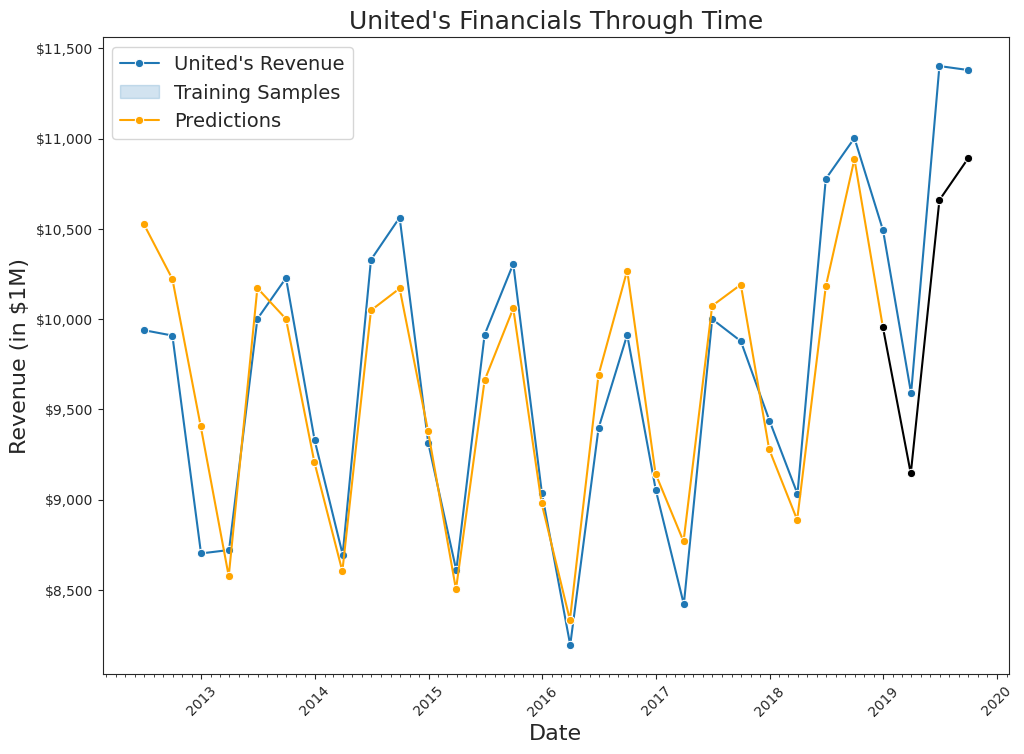

In [ ]:
def plot_prediction_time_series(dates_train, train, dates_test, pred, dates_truth, truth, title, x_label, y_label):

    years_locator = mdates.YearLocator()
    months_locator = mdates.MonthLocator()
    years_format = mdates.DateFormatter('%Y')

    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)

    ax.ticklabel_format(axis='y', style='plain')

    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))

    ax.xaxis.set_major_locator(years_locator)
    ax.xaxis.set_major_formatter(years_format)
    ax.xaxis.set_minor_locator(months_locator)

    sns.lineplot(x=dates_truth, y=truth, marker='o')
    sns.lineplot(x=dates_train, y=train, color='orange', marker='o')

    dates_pred = list(dates_train[-1:]) + list(dates_test)
    plot_pred = list(train[-1:]) + list(pred)

    sns.lineplot(x=dates_pred, y=plot_pred, color='black', marker='o')

    plt.legend(labels=['United\'s Revenue', 'Training Samples', 'Predictions'], fontsize='14')

    rotation = 45
    plt.setp(ax.get_xticklabels(), rotation=rotation)
    plt.title('United\'s Financials Through Time', fontsize='18')
    plt.xlabel('Date', fontsize='16')
    plt.ylabel('Revenue (in $1M)', fontsize='16')

    plt.show()

plot_prediction_time_series(dates_train, rmod.predict(X_train), dates_test, pred, united_revenues[-30:]['DATE'], united_revenues[-30:]['REVENUE'], 'Predicted United Revenues', 'Date', 'Revenue ($ Million)')


### Building our model using X_maximal

Next, let's try the maximal regression model, $Revenue_t = f(P_{t-3}, P_{t-4}, P_{t-5}, P_{t-6}, P_{t-7}, P_{t-8}, P_{t-9}, P_{t-10}, P_{t-11}, P_{t-12}, P_{t-13}, P_{t-14}, C_{t-3}, C_{t-4}, C_{t-5}, C_{t-6}, C_{t-7}, C_{t-8}, C_{t-9}, C_{t-10}, C_{t-11}, C_{t-12}, C_{t-13}, C_{t-14}, K_{t}, K_{t-1}, K_{t-2}, K_{t-3}, K_{t-4}, K_{t-5}, K_{t-6}, K_{t-7}, K_{t-8}, K_{t-9}, K_{t-10}, K_{t-11})$

In [ ]:
#Splitting the data
dates_train = dates_maximal[:-3]
dates_test = dates_maximal[-3:]

X_train, y_train = X_maximal[:-3], y_maximal[:-3]
X_test, y_test = X_maximal[-3:], y_maximal[-3:]

#Building the Model
rmod = linear_model.LinearRegression()
rmod.fit(X_train, y_train)

#Using and Checking the Model
pred = rmod.predict(X_train)
rmse= mean_squared_error(y_train, pred, squared=False)
r_squared = r2_score(y_train, pred)

print('Training Error:')

print(f'Root Mean Square Error: {rmse}')
print(f'R-squared: {r_squared}')

print('Test Error:')

pred = rmod.predict(X_test)
rmse= mean_squared_error(y_test, pred, squared=False)
r_squared = r2_score(y_test, pred)

print(f'Root Mean Square Error: {rmse}')
print(f'R-squared: {r_squared}')

Training Error:
Root Mean Square Error: 6.190802455925264e-12
R-squared: 1.0
Test Error:
Root Mean Square Error: 390.8059687517542
R-squared: 0.7883702250164548


The output indicates that the training error metrics are significantly lower than the test error metrics. This discrepancy suggests potential overfitting of the model. **Overfitting** happens when a model learns too much from the training data, capturing noise or random fluctuations rather than the underlying pattern. Essentially, the model fits the training data too closely, making it perform poorly on new, unseen data.

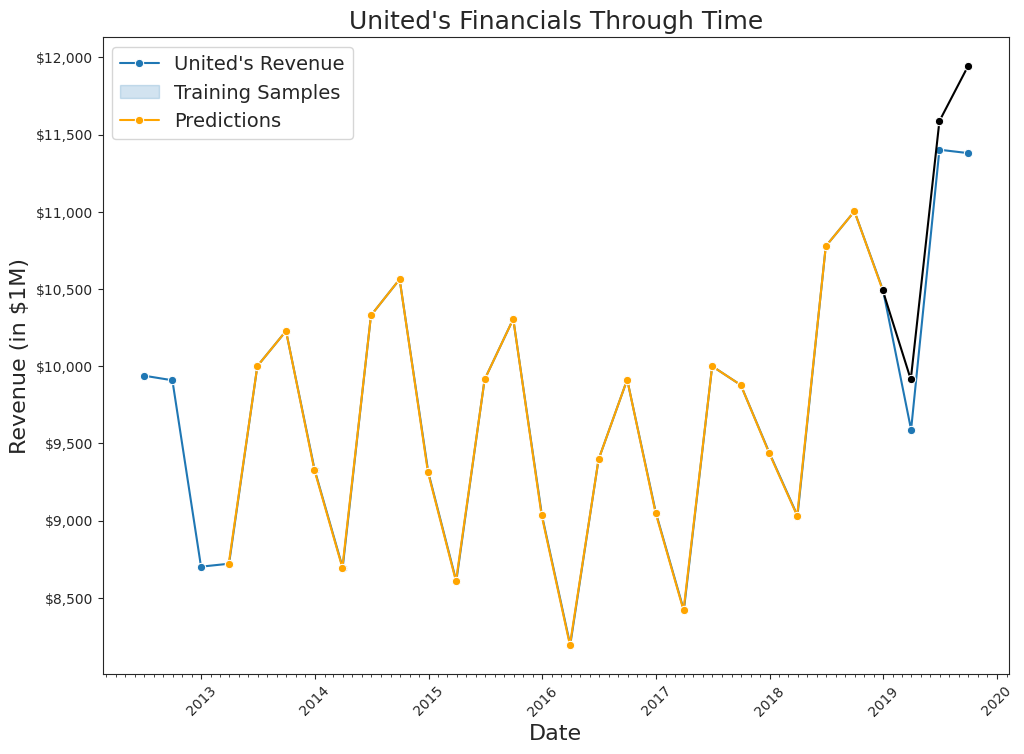

In [ ]:
plot_prediction_time_series(dates_train, rmod.predict(X_train), dates_test, pred, united_revenues[-30:]['DATE'], united_revenues[-30:]['REVENUE'], 'Predicted United Revenues', 'Date', 'Revenue ($ Million)')



As you can see, throwing all the variables at the problem actually makes the model overfit by perfectly tracking the training data. Getting an R-squared of 1.0 is very unusual on real data. This may suggest that our model is not capable of generalizing the training data.

### Comparing the models

Let's use the Root Mean Square Error (RMSE) values on the test data to compare the models we built:
- The minimal model has an $RMSE \approx574$
- The maximal model has an $RMSE \approx391$

Interestingly, despite concerns of overfitting, the maximal model appears to outperform the minimal model. This is surprising as overfitting usually leads to poorer performance.

These values suggest that the miniml and maximal predictions are off by around $\$574 M$ and $\$391 M$, respectively. Considering United's revenue range is from $\$8 B$ to $\$12 B$ and the small size of our dataset, our results aren't too bad. But of course, we should always strive to do better! Maybe it performs better with other airline data or more training data,

#### Next Steps

The next steps involve implementation, evaluation, refinement, and integration:

1. **Implementation**: Deploy the chosen model for predicting revenue for the upcoming quarter.
2. **Evaluation**: Continuously monitor the model's performance against actual results and identify areas for improvement.
3. **Refinement**: Adjust the model parameters, incorporate additional features or data sources, or explore alternative modeling techniques to improve performance.
4. **Integration**: Integrate the revenue prediction model into decision-making processes, such as informing investment decisions or asset allocation strategies.

It's also important to do the following:
5. **Documentation and Communication**: Thoroughly document the model's implementation, assumptions, and limitations, and effectively communicate these details to stakeholders within the firm.
6. **Exploration of Alternatives**: Continuously explore alternative approaches to improve the model's performance, such as time series analysis and/or neural networks.

By following these steps, your asset management firm can leverage the predictive power of the revenue model to optimize portfolio performance and make more informed investment decisions.

## Conclusion

In this case, we completed a data science project, encompassing data collection, design of new features derived from the data, and finally, model building to predict airline revenue. By comprehensively understanding our problem and its real-world implications, we achieved a more refined result in the end. The ability to work with diverse data sources and develop predictive models are pivotal skills utilized in an asset management firm.





## Takeaways

Data science is much more than knowing the latest methods and the tools of the trade. If you ask what makes a good carpenter, you would not answer with "someone that knows how to use a hammer". These should be the points you should focus on from this case:

1. Understand your problem first. If you don't have a clear objective, you'll be left wandering. Assess your data according to your goal.

1. Real data science requires trial and error. Even the best data sources make mistakes. You should constantly validate input and output.